# Methodologies for image processing of radar remote sensing data #
## Lecture 3. Empirical Analyses (Execrise) ##
### Shiyi Li ###

## Introduction ##
This execrise aims at deepening the knowledge about hypotheses testing. By finishing this execrise, the student should be able to:

1. Understand the concept of hypothesis testing
2. Design hypothesis testing for simple image segmentation problem
3. Identify type I error and type II error, and interprete the result 
4. Identify significance level and probability of detection, and identify their influence on results.

The material used in this execrise includes the SAR image of Zurich acquired by Sentinel-1 at 2019-10-04 [1]. The previw of the SAR image is provided in the following figure. The optical image of the same area is also provided as a reference. 

In the execrise, you will be asked to examine the SAR image of Zurich, and perform hypothesis testing to discriminate water boday and non-water body in the image. 

<img src="zurich_map.pdf" alt="some text"  width="600" height="600">

In [1]:
# Load necessary packages
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
from rasterio.plot import show
from rasterio.windows import Window
from scipy.stats import norm
from matplotlib.patches import Rectangle
from IPython.display import display, Latex
import matplotlib.ticker as mtick

In [2]:
# Read in the SAR img
# In the filename, change 'vv' to 'vh' can 
# import SAR image of diifferent polarimetry channel

imgfile = Path('s1a_vv_20191004_zurich.tif')

with rasterio.open(imgfile, 'r') as src:
    img = src.read(1)
    img_meta = src.profile

## 1. Build statitical model of the pixel value on water surface

The first step is to observe the distribution of pixel values on water area and non-water area, then we can build a statistical model based on the observation. 

We assume that the pixel value of the water area follows a Normal distribution. To construct a model, we need to know the mean($\mu$) and standard deviation ($\sigma$) of the Normal distribution.

The following function may help you check the histogram of pixel values in a region of interest (ROI). 

In [3]:
def check_hist_region(win, img, figsize=[10, 5], hist_bin=100):
    
    """
    Examine the histogram of the region of interest (ROI).
    
    The function takes the ROI window and raw sar image as input and
    display the histogram of the ROI, as well as the fitted PDF.
    
    Parameters
    ----------
    win : tuple
        The ROI window, defined as (row_start, col_start, width, height)
    img : numpy array
        The full image from which the ROI is taken
    figsize : list or tuple, optional
        The size of figure for plot, (default is [10, 5])    
    hist_bin : int, optional
        The bins of the histogram
        
    Return
    ----------
    zone: the ROI array
    mu: the mean of the estimated normal distribution
    std: the standard deviation of the estimated normal distribution
    """
    
    y, x, w, h = win
    zone = img[y:y+h, x:x+w]
    zone_flat = zone.ravel()
    mu, std = norm.fit(zone_flat)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    hist_param = dict(density=True, color='#0504aa',alpha=0.7, rwidth=0.85)
    
    density, bins, _ = ax1.hist(zone_flat, bins=hist_bin, **hist_param)
    
    _x = (bins[0:-1] + bins[1:]) / 2
    p = norm.pdf(_x, mu, std)
    l = ax1.plot(_x, p, 'r--', linewidth=2)
    
    text_str = r'$\mu = %.2f$' % mu + '\n' + '$\sigma^2 = %.2f$' % std
    ax1.text(0.9, 0.9, text_str, ha='right', va='top', fontsize=12, transform=ax1.transAxes)
    show(np.log10(img), cmap='gray', ax=ax2, vmin=1.5, vmax=3)
    
    # Create a Rectangle patch
    rect = Rectangle(xy=(x, y), width=w, height=h, linewidth=1, ec='r', fc='none')
    ax2.add_patch(rect)
    
    ax2.grid('True')
    
    plt.show()
    
    return zone, mu, std

**Task:**

Use the above function to check the histogram of pixels falling in Zurich Lake. 

Change the roi_window to detect different regions. 

Compare the histogram of water body and non-water boday, notice the difference in between. 

Try different window size to decide optimum statistic, note down the optimum statistic ($\mu$, $\sigma^2$) for hypothesis testing.

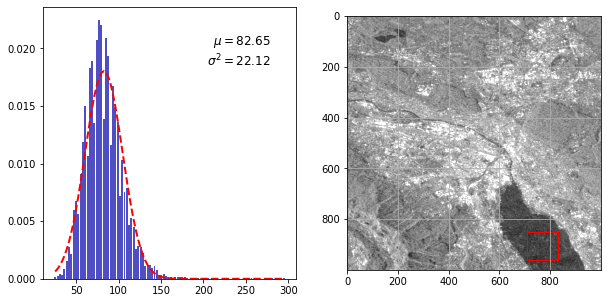

In [4]:
# window format: (row_start, col_start, width, height)
roi_window = (850, 710, 120, 110) 

roi, _mu, _std = check_hist_region(roi_window, img)

## 2. Perform hypothesis testing to discriminate water and non-water

In step-1, we built up a statistical model that describes the pixel value distribution of water body. 

To perform the hypothesis testing, we need to:

- make the hypothesis statements
- choose a proper threshold
- calculate the probability of the pixel value given the null hypothesis is true.
- accept or reject the hypothesis 

**Task: Make your hypothesis statements ($H_0$ and $H_1$) before continuing.**

In [5]:
# Build your statistical model by filling up the parameters 
mu = 82
std = 22

alpha = 0.05 # threshold, in percent

# H0_state = r"" % (mu, std)
# H1_state = r"$H_1$: The given pixel is NOT on a water-body (i.e. the pixel value does NOT follow the distribution $\mathcal{N}(\mu=%.2f, \simga^2=%.2f)$)" % (mu, std)

# display(Markdown(r'$H_0$: The given pixel is on a water-body (i.e. the pixel value follows $\mathcal{N}(\mu=%.2f, \simga^2=%.2f)$)' % (mu, std)))
# display(Math(r'\\H_1\\'), ': The given pixel is NOT on a water-body (i.e. the pixel value does NOT follow', Math('$\mathcal{N}(\mu=%.2f, \simga^2=%.2f)$)' % (mu, std)))

H0_state = r"$H_0$: The given pixel is on a water-body i.e. the pixel value follows $\mathcal{N}(\mu=%.2f, \sigma^2=%.2f)$ ." % (mu, std)
H1_state = r"$H_1$: The given pixel is NOT on a water-body i.e. the pixel value does NOT follow $\mathcal{N}(\mu=%.2f, \sigma^2=%.2f)$ ." % (mu, std)

display(Latex(H0_state))
display(Latex(H1_state))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Now that we have the hypotheses ready, we can calculate the probability of every pixel in the image assuming the null hypothesis is true, and decide to accept or reject the null hypothesis. The function below can help you do the calculation.

In [6]:
def hypo_test_water(arr, h0=(82, 25), alpha=0.05):
    
    """
    Perform hypothesis testing on each element of a given array.
    
    Parameters
    ----------
    arr : numpy array
        The array whose element is tested
    h0 : tuple, optional
        The parameter of h0 statement in (mu, std), (default is (82, 25))
    alpha : float, optional
        The threshold based on which the hypothesis is accepted or rejected
        
    Return:
    ----------
    segment: the segmented image, whose values are either 0 - accept H0 or 1 - reject H0
    pdf_distr: the propability of each element in the image assuming H0 is true
    """
    
    shape = arr.shape
    mu, std = h0
    pdf = norm.pdf(arr.ravel(), mu, std)
    
    pdf_distr = np.reshape(pdf, shape)
    segment = (pdf_distr > alpha/100).astype(int)
    
    return segment, pdf_distr

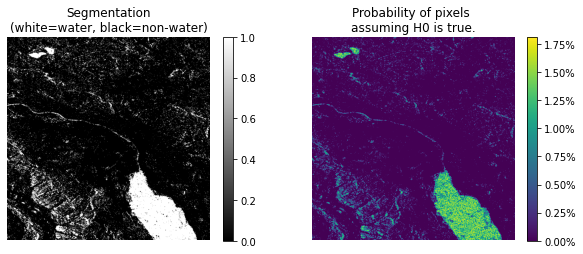

In [14]:
# Change the statistical model parameter (mu, std) or alpha 
# will change the segmentation result.

seg, pdf = hypo_test_water(img, h0=(mu, std), alpha=alpha)


# Plot the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
im = ax1.imshow(seg, cmap='gray')
ax1.set_title('Segmentation\n(white=water, black=non-water)')
plt.colorbar(im, ax=ax1, shrink=0.75)

im = ax2.imshow(pdf, cmap='viridis')
ax2.set_title('Probability of pixels \nassuming H0 is true.')
plt.colorbar(im, ax=ax2, shrink=0.75, format=mtick.FuncFormatter(lambda y, _: '{:.2f}%'.format(y*100)))

for ax in [ax1, ax2]:
    ax.axis('off')

plt.show()

In [ ]:
# zone = img[375:425, 775:825]
plt.hist(img.ravel(), 100, range=[0, 1e3])
plt.show()